<a href="https://colab.research.google.com/github/marcofloresm/AngularJSPhoneCat/blob/master/Refactorizado_CLAHE_998_RED_NEURONAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Cargar dataset de imágenes en memoria**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!unzip /content/drive/MyDrive/mejora.zip -d /content/mejora/
#!unzip /content/drive/MyDrive/dermnet_real.zip -d /content/
#!unzip /content/drive/MyDrive/dermnet_modi.zip -d /content/

#!unzip /content/drive/MyDrive/imagen_244x224.zip -d /content/

#!unzip /content/drive/MyDrive/skin_lesion_m_b.zip -d /content/

!unzip /content/drive/MyDrive/real.zip -d /content/real/
#!unzip /content/drive/MyDrive/real2.zip -d /content/

Defino las rutas de colab de las imagenes

In [ ]:

paths=["/content/drive/MyDrive/MejoraImagenReal/train/",
       "/content/drive/MyDrive/MejoraImagenReal/test/"]

paths=["/content/dermnet_real/train/",
       "/content/dermnet_real/test/"]

paths=["/content/imagen_244x224/train/",
       "/content/imagen_244x224/test/"]

paths=["/content/skin_lesion_m_b/train/",
       "/content/skin_lesion_m_b/test/"]

paths=["/content/real/train/",
       "/content/real/test/"]


Etiquetas=2
baseImagen="ISIC"
epochs_DATA=50
tamano_imagen=224
num_epochs=50


In [ ]:
# https://pypi.python.org/pypi/libarchive
#!apt-get -qq install -y libarchive-dev && pip install -U libarchive
#import libarchive

In [ ]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path
from io import BytesIO
from PIL import Image, ImageEnhance
import pandas as pd
import numpy as np
import requests
import random
import glob
import cv2
import os

import math
import scipy
import tensorflow as tf
import tensorflow as tfc
from sklearn import metrics

from tensorflow.keras import applications
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# for Transfer Learning
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import EfficientNetB7

%matplotlib inline

In [ ]:
def imshow(img):
    fig,ax = plt.subplots(1,1,figsize=(8,8))
    ax.imshow(img,cmap='gray')

In [ ]:
possible_labels=os.listdir(paths[1])

In [ ]:
possible_labels

['malignant', 'benign']

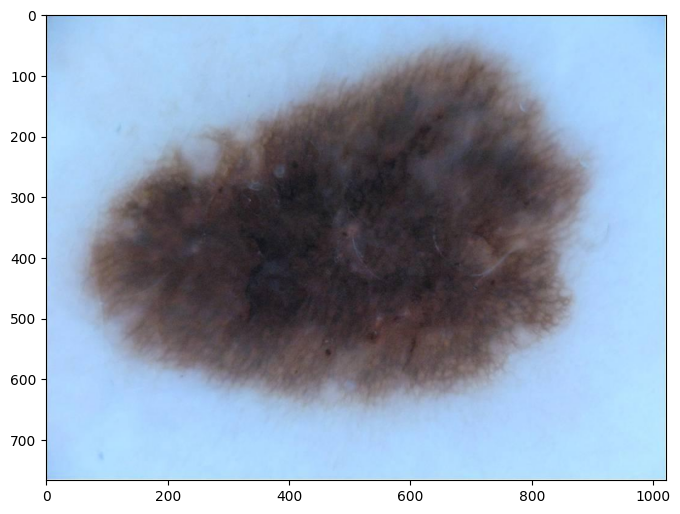

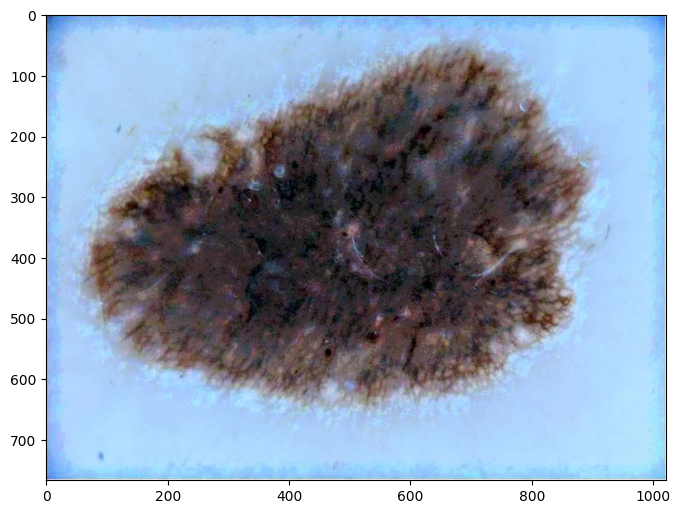

In [ ]:
from PIL import Image, ImageFilter
from PIL import ImageEnhance

photo = Image.open("/content/real/test/benign/ISIC_0000000.jpg")

photo.filter(ImageFilter.GaussianBlur(radius = 20)).save("ISIC_0000000.jpg")
photo.filter(ImageFilter.UnsharpMask(radius = 20,percent = 200,threshold = 5)).save("ISIC_0000000.jpg")

photo_mod = Image.open("ISIC_0000000.jpg")
photo_mod.show()
imshow(photo)
imshow(photo_mod)

In [ ]:
def oscurecer_imagen(imagen_path, factor_oscurecimiento):
    # Abrir la imagen
    imagen = Image.open(imagen_path)
    # Crear un objeto ImageEnhance para oscurecer la imagen
    enhancer = ImageEnhance.Brightness(imagen)
    # Aplicar el factor de oscurecimiento
    imagen_oscurecida = enhancer.enhance(factor_oscurecimiento)
    # Guardar la imagen oscurecida o mostrarla
    #imagen_oscurecida.show()
    # Si prefieres guardar la imagen oscurecida en un archivo, puedes usar:
    # imagen_oscurecida.save("imagen_oscurecida.jpg")
    return imagen_oscurecida

Oscurecer

In [ ]:
data=[]
cuenta=0
for i,path in enumerate(paths):
    for label_int, label_string in enumerate(possible_labels):
        for filename in glob.glob(path+label_string+'/*.jpg'):
            img=cv2.imread(filename)
            factor_oscurecimiento = 1.0
            # Llamar a la función para oscurecer la imagen
            ruta_imagen=filename
            img2=oscurecer_imagen(ruta_imagen, factor_oscurecimiento)
            img2.save(ruta_imagen)
            data.append( [label_int,cv2.resize(img,(tamano_imagen,tamano_imagen))] )
            cuenta=cuenta+1
            if cuenta % 100 == 0: # [+] informa la carga cada 100 imagenes.
              print(cuenta,'images loaded')

len(data)

100 images loaded
200 images loaded
300 images loaded
400 images loaded
500 images loaded
600 images loaded
700 images loaded
800 images loaded
900 images loaded


998

# Aclarar CLAHE

In [ ]:
def show_img_with_matplotlib(color_img, title, pos):
    """Shows an image using matplotlib capabilities"""

    # Convert BGR image to RGB
    img_RGB = color_img[:, :, ::-1]

    ax = plt.subplot(2, 5, pos)
    plt.imshow(img_RGB)
    plt.title(title)
    plt.axis('off')


def equalize_clahe_color_hsv(img):
    """Equalize the image splitting it after conversion to HSV and applying CLAHE
    to the V channel and merging the channels and convert back to BGR
    """

    cla = cv2.createCLAHE(clipLimit=4.0)
    H, S, V = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
    eq_V = cla.apply(V)
    eq_image = cv2.cvtColor(cv2.merge([H, S, eq_V]), cv2.COLOR_HSV2BGR)
    return eq_image


def equalize_clahe_color_lab(img):
    """Equalize the image splitting it after conversion to LAB and applying CLAHE
    to the L channel and merging the channels and convert back to BGR
    """

    cla = cv2.createCLAHE(clipLimit=4.0)
    L, a, b = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2Lab))
    eq_L = cla.apply(L)
    eq_image = cv2.cvtColor(cv2.merge([eq_L, a, b]), cv2.COLOR_Lab2BGR)
    return eq_image


def equalize_clahe_color_yuv(img):
    """Equalize the image splitting it after conversion to YUV and applying CLAHE
    to the Y channel and merging the channels and convert back to BGR
    """

    cla = cv2.createCLAHE(clipLimit=4.0)
    Y, U, V = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2YUV))
    eq_Y = cla.apply(Y)
    eq_image = cv2.cvtColor(cv2.merge([eq_Y, U, V]), cv2.COLOR_YUV2BGR)
    return eq_image


def equalize_clahe_color(img):
    """Equalize the image splitting the image applying CLAHE to each channel
    and merging the results
    """

    cla = cv2.createCLAHE(clipLimit=4.0)
    channels = cv2.split(img)
    eq_channels = []
    for ch in channels:
        eq_channels.append(cla.apply(ch))

    eq_image = cv2.merge(eq_channels)
    return eq_image

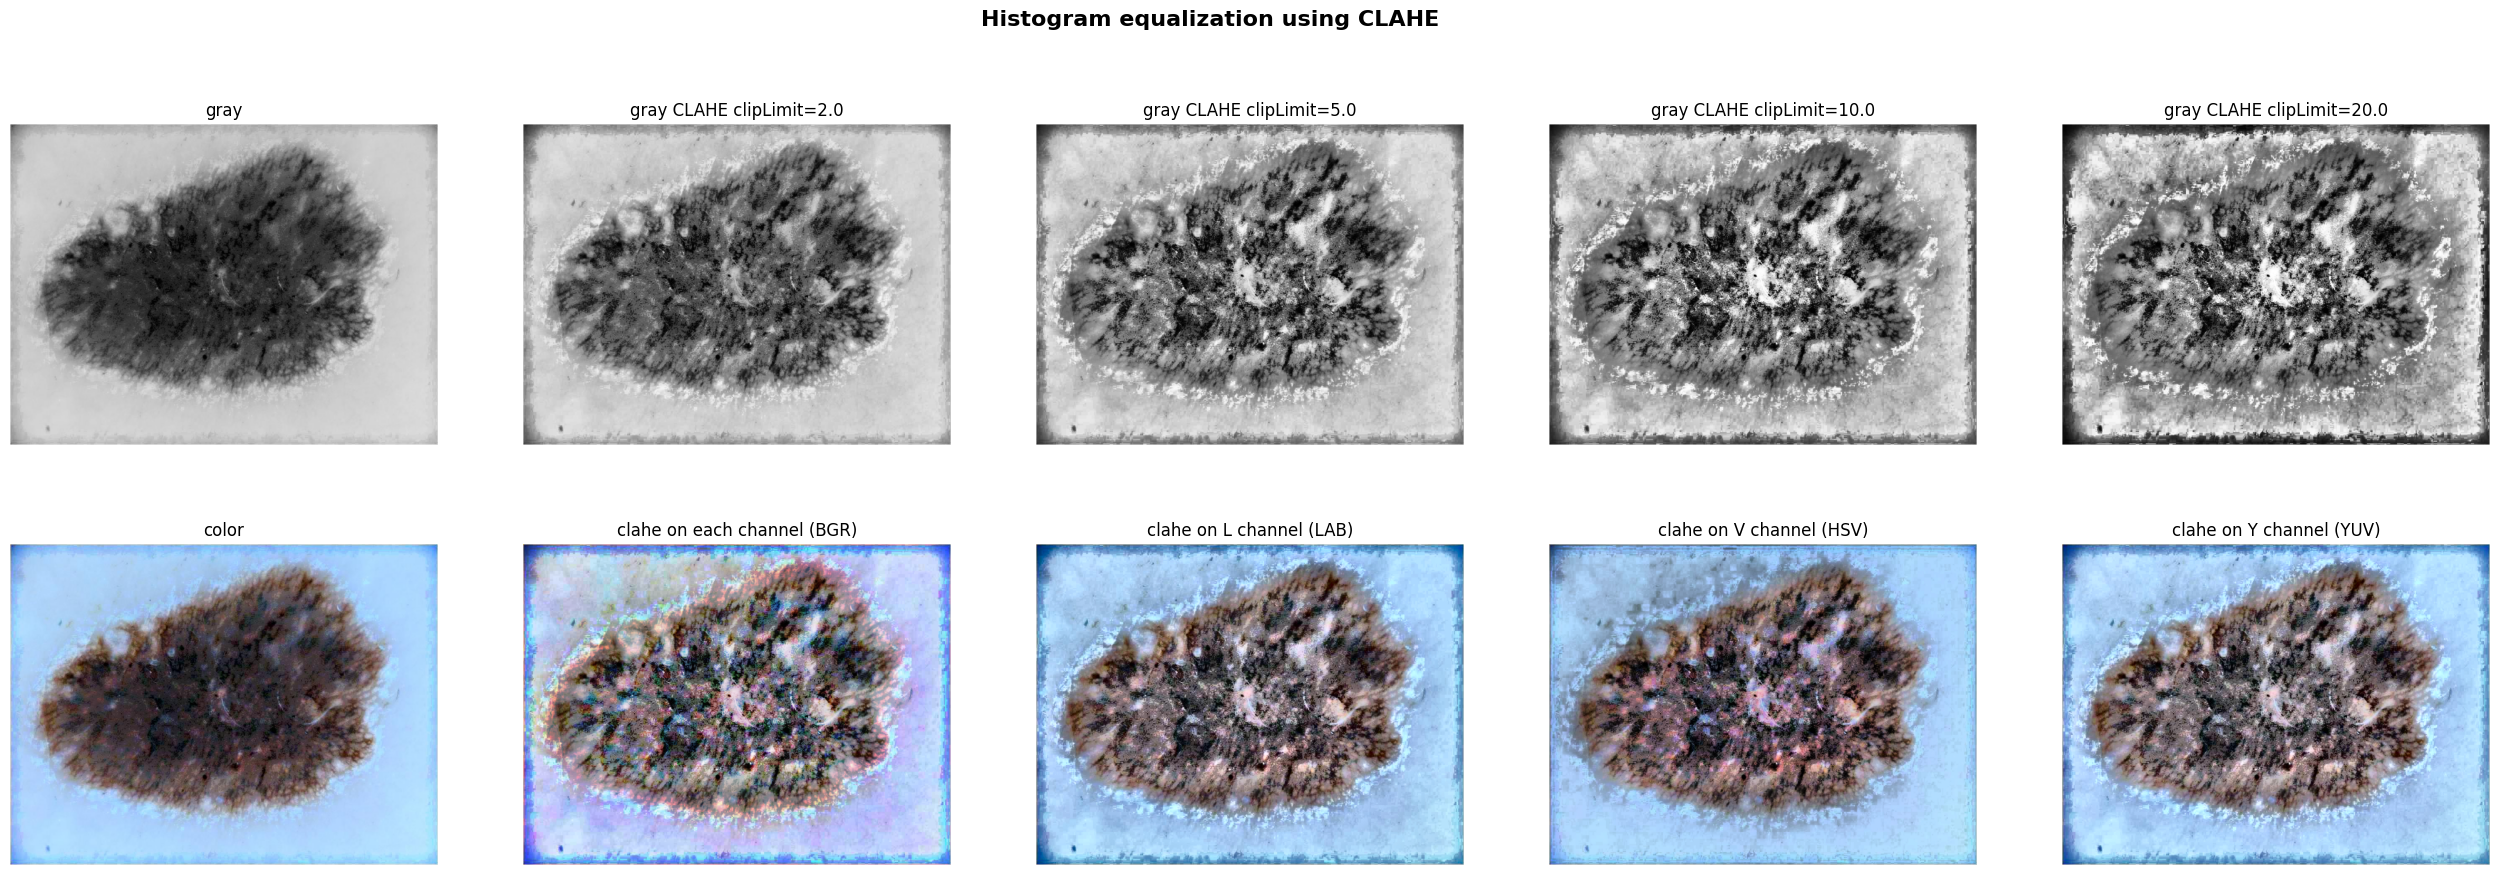

In [ ]:
# Create the dimensions of the figure and set title:
plt.figure(figsize=(32, 10))
plt.suptitle("Histogram equalization using CLAHE", fontsize=16, fontweight='bold')

# Load the image and convert it to grayscale:
image = cv2.imread("/content/ISIC_0000000.jpg")
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Create clahe:
clahe = cv2.createCLAHE(clipLimit=2.0)
# Apply CLAHE to the grayscale image varying clipLimit parameter:
gray_image_clahe = clahe.apply(gray_image)
clahe.setClipLimit(5.0)
gray_image_clahe_2 = clahe.apply(gray_image)
clahe.setClipLimit(10.0)
gray_image_clahe_3 = clahe.apply(gray_image)
clahe.setClipLimit(20.0)
gray_image_clahe_4 = clahe.apply(gray_image)

# Now, try the four created functions for equalize color images using CLAHE:
image_clahe_color = equalize_clahe_color(image)
image_clahe_color_lab = equalize_clahe_color_lab(image)
image_clahe_color_hsv = equalize_clahe_color_hsv(image)
image_clahe_color_yuv = equalize_clahe_color_yuv(image)

# Plot all the images
show_img_with_matplotlib(cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR), "gray", 1)
show_img_with_matplotlib(cv2.cvtColor(gray_image_clahe, cv2.COLOR_GRAY2BGR), "gray CLAHE clipLimit=2.0", 2)
show_img_with_matplotlib(cv2.cvtColor(gray_image_clahe_2, cv2.COLOR_GRAY2BGR), "gray CLAHE clipLimit=5.0", 3)
show_img_with_matplotlib(cv2.cvtColor(gray_image_clahe_3, cv2.COLOR_GRAY2BGR), "gray CLAHE clipLimit=10.0", 4)
show_img_with_matplotlib(cv2.cvtColor(gray_image_clahe_4, cv2.COLOR_GRAY2BGR), "gray CLAHE clipLimit=20.0", 5)
show_img_with_matplotlib(image, "color", 6)
show_img_with_matplotlib(image_clahe_color, "clahe on each channel (BGR)", 7)
show_img_with_matplotlib(image_clahe_color_lab, "clahe on L channel (LAB)", 8)
show_img_with_matplotlib(image_clahe_color_hsv, "clahe on V channel (HSV)", 9)
show_img_with_matplotlib(image_clahe_color_yuv, "clahe on Y channel (YUV)", 10)

# Show the Figure:
plt.show()

In [ ]:
#data=[]
cuenta=0
for i,path in enumerate(paths):
    for label_int, label_string in enumerate(possible_labels):
        for filename in glob.glob(path+label_string+'/*.jpg'):
            img=cv2.imread(filename,0)
            #img_RGB = img[:, :, ::-1]
            #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            #equ = cv2.equalizeHist(img)
            clahe = cv2.createCLAHE(clipLimit =2.0,tileGridSize=(8,8))
            cl_img = clahe.apply(img)
            clahe_rgb = cv2.merge([cl_img, cl_img, cl_img])
            # Llamar a la función para oscurecer la imagen
            ruta_imagen=filename
            #img2=oscurecer_imagen(ruta_imagen, factor_oscurecimiento)
            #clahe_rgb.save(ruta_imagen)
            cv2.imwrite(ruta_imagen, clahe_rgb)
            #data.append( [label_int] )
            #data.append( [label_int,cv2.resize(img,(tamano_imagen,tamano_imagen))] )
            cuenta=cuenta+1
            if cuenta % 100 == 0: # [+] informa la carga cada 100 imagenes.
              print(cuenta,'images loaded')
len(data)

100 images loaded
200 images loaded
300 images loaded
400 images loaded
500 images loaded
600 images loaded
700 images loaded
800 images loaded
900 images loaded


998

In [ ]:
import random
random.Random(0).shuffle(data)

x_train=[]
y_train=[]

x_val=[]
y_val=[]

x_test=[]
y_test=[]

for i, sample in enumerate(data):
    label=sample[0]
    img=sample[1]
    if i<= 0.7*len(data):
        x_train.append(img)
        y_train.append(label)
    elif i>0.8*len(data) and i<=0.9*len(data):
        x_val.append(img)
        y_val.append(label)
    else:
        x_test.append(img)
        y_test.append(label)

x_train=np.array(x_train)
x_val=np.array(x_val)
x_test=np.array(x_test)

y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

In [ ]:
x_test.shape

(199, 224, 224, 3)

In [ ]:
x_train.shape

(699, 224, 224, 3)

In [ ]:
x_train.shape

(699, 224, 224, 3)

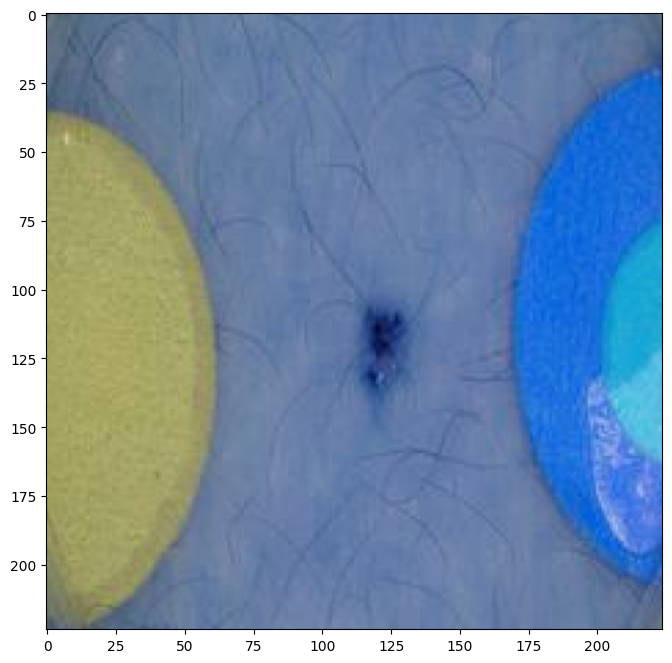

In [ ]:
imshow(x_train[1])

In [ ]:
y_train[0]

1

In [ ]:
possible_labels[y_train[0]]

'benign'

In [ ]:
train_data_path = '/content/real/train'  #path[0] #'/content/imagen_244x224/train'
validation_data_path = '/content/real/test' #path[1] #'/content/imagen_244x224/test'
#train_data_path = '/content/imagen_244x224/train'
#validation_data_path = '/content/imagen_244x224/test'
#train_data_path = '/content/skin_lesion_m_b/train'
#validation_data_path = '/content/skin_lesion_m_b/test'

imagen_dematologica = os.listdir(train_data_path)
img_width, img_height = tamano_imagen, tamano_imagen
batch_size = 32

print("Number of Categories:", len(imagen_dematologica))
print("Categories: ", imagen_dematologica)

Number of Categories: 2
Categories:  ['malignant', 'benign']


In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range = 0,
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rotation_range = 0,rescale=1. / 255,zoom_range=0.2,shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 868 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


# Definición y entrenamiento de la red

In [ ]:
def plot_history(history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    #epochs = len(history.history['acc'])
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    #axs[0].plot(history.history['step'])
    axs[0].set_title('Model Accuracy - Precisión')
    axs[0].set_ylabel('Accuracy - Precisión')
    axs[0].set_xlabel('Epoch - Epoca')
    axs[0].legend(['train', 'validate'], loc='upper left')

    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss -  Costo')
    axs[1].set_ylabel('Loss - Costo')
    axs[1].set_xlabel('Epoch - Epoca')
    axs[1].legend(['train', 'validate'], loc='upper left')

    plt.show()

# history = pd.read_csv(TRAINING_LOG_PATH, sep=',', engine='python')
#plot_history(history)

# RestNet50

In [ ]:
model_base = ResNet50(weights='imagenet',include_top=False)

x = model_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512,activation='relu')(x)
predictions = layers.Dense(int(len(train_generator.class_indices.keys())) ,activation='softmax')(x)
Resnet50_model = models.Model(inputs= model_base.input, outputs=predictions)


In [ ]:
Resnet50_model.compile(loss='categorical_crossentropy',
                       optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=1e-4, momentum=0.9) ,
                       metrics=['accuracy'])

In [ ]:
historyResnet50 = Resnet50_model.fit(train_generator,
                                               epochs=num_epochs,
                                               shuffle=True, verbose=1,
                                               validation_data=validation_generator)

Epoch 1/50
28/28 [==============================] - 41s 669ms/step - loss: 0.5187 - accuracy: 0.7604 - val_loss: 0.6611 - val_accuracy: 0.6923
Epoch 2/50
28/28 [==============================] - 17s 599ms/step - loss: 0.3264 - accuracy: 0.8652 - val_loss: 0.6488 - val_accuracy: 0.6923
Epoch 3/50
28/28 [==============================] - 17s 592ms/step - loss: 0.2787 - accuracy: 0.8744 - val_loss: 2.0895 - val_accuracy: 0.6923
Epoch 4/50
28/28 [==============================] - 17s 590ms/step - loss: 0.2656 - accuracy: 0.8952 - val_loss: 2.5454 - val_accuracy: 0.6923
Epoch 5/50
28/28 [==============================] - 17s 592ms/step - loss: 0.2552 - accuracy: 0.8929 - val_loss: 3.3015 - val_accuracy: 0.6923
Epoch 6/50
28/28 [==============================] - 17s 611ms/step - loss: 0.2316 - accuracy: 0.8975 - val_loss: 3.9927 - val_accuracy: 0.6923
Epoch 7/50
28/28 [==============================] - 17s 609ms/step - loss: 0.2309 - accuracy: 0.9032 - val_loss: 4.8493 - val_accuracy: 0.6923

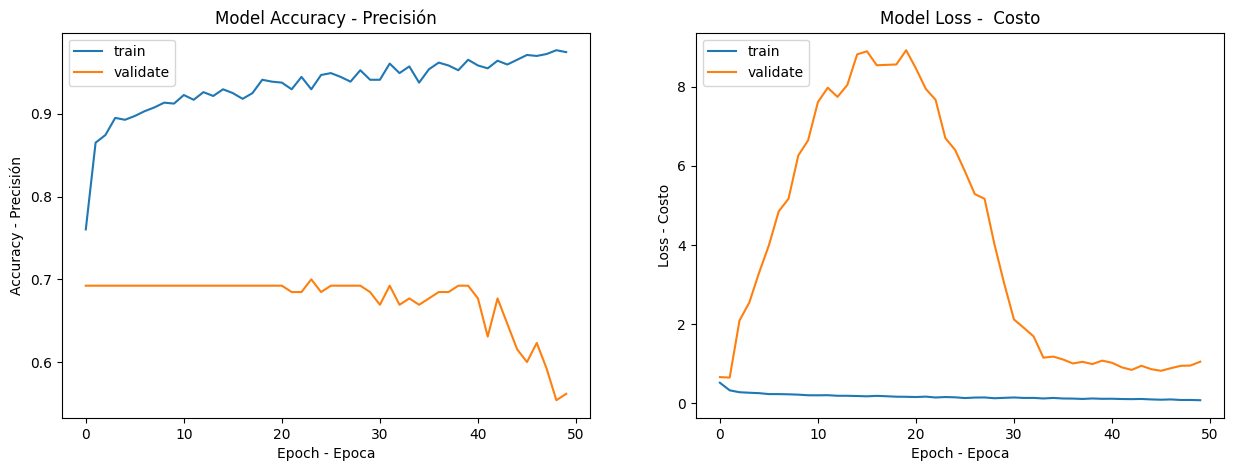

In [ ]:
plot_history(historyResnet50)

In [ ]:
# Evaluar el modelo
lossResnet50, accuracyResnet50 = Resnet50_model.evaluate(validation_generator, steps=len(validation_generator))
print('Loss Resnet50:', lossResnet50)
print('Accuracy Resnet50:', accuracyResnet50)

5/5 [==============================] - 3s 527ms/step - loss: 0.9901 - accuracy: 0.6077
Loss Resnet50: 0.990062415599823
Accuracy Resnet50: 0.607692301273346


In [ ]:
model_base.save('/content/drive/MyDrive/modelos/isic/aclarado_Clahe_224x224_Resnet50.keras')

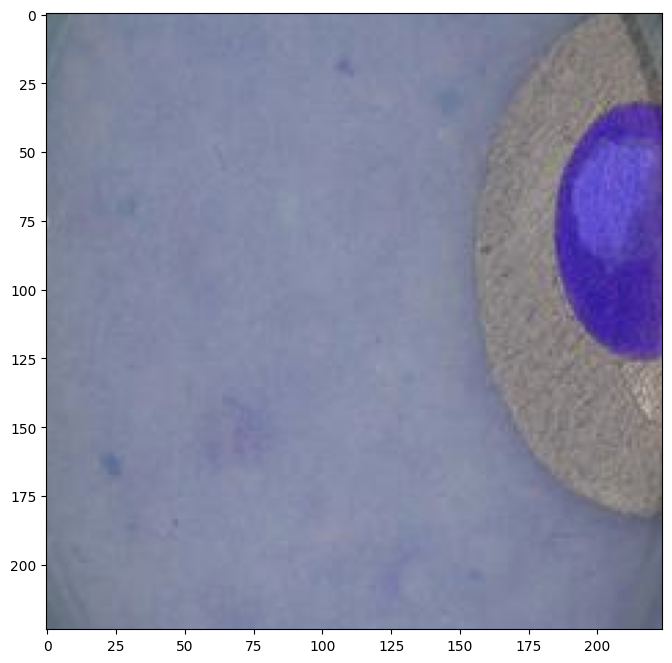

In [ ]:
import matplotlib.pyplot as plt
imshow(img)

# Mobilenet


In [ ]:
model_base = MobileNet(weights='imagenet',include_top=False)

x = model_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512,activation='relu')(x)
predictions = layers.Dense(int(len(train_generator.class_indices.keys())) ,activation='softmax')(x)
MobileNet_model = models.Model(inputs= model_base.input, outputs=predictions)


17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
MobileNet_model.compile(loss='categorical_crossentropy',
                        optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9) ,
                        metrics=['accuracy'])

In [ ]:
hist_mobile = MobileNet_model.fit(train_generator,
                                            epochs=num_epochs,
                                            shuffle=True,
                                            verbose=1,
                                            validation_data=validation_generator)

Epoch 1/50
28/28 [==============================] - 25s 605ms/step - loss: 0.5357 - accuracy: 0.7373 - val_loss: 0.7174 - val_accuracy: 0.5769
Epoch 2/50
28/28 [==============================] - 16s 592ms/step - loss: 0.3619 - accuracy: 0.8641 - val_loss: 0.7714 - val_accuracy: 0.5538
Epoch 3/50
28/28 [==============================] - 17s 590ms/step - loss: 0.3166 - accuracy: 0.8641 - val_loss: 0.7116 - val_accuracy: 0.6154
Epoch 4/50
28/28 [==============================] - 17s 590ms/step - loss: 0.2942 - accuracy: 0.8710 - val_loss: 0.7285 - val_accuracy: 0.7000
Epoch 5/50
28/28 [==============================] - 16s 587ms/step - loss: 0.2692 - accuracy: 0.8882 - val_loss: 0.7061 - val_accuracy: 0.6692
Epoch 6/50
28/28 [==============================] - 16s 592ms/step - loss: 0.2559 - accuracy: 0.8767 - val_loss: 0.7313 - val_accuracy: 0.6615
Epoch 7/50
28/28 [==============================] - 17s 597ms/step - loss: 0.2490 - accuracy: 0.8963 - val_loss: 0.7513 - val_accuracy: 0.6538

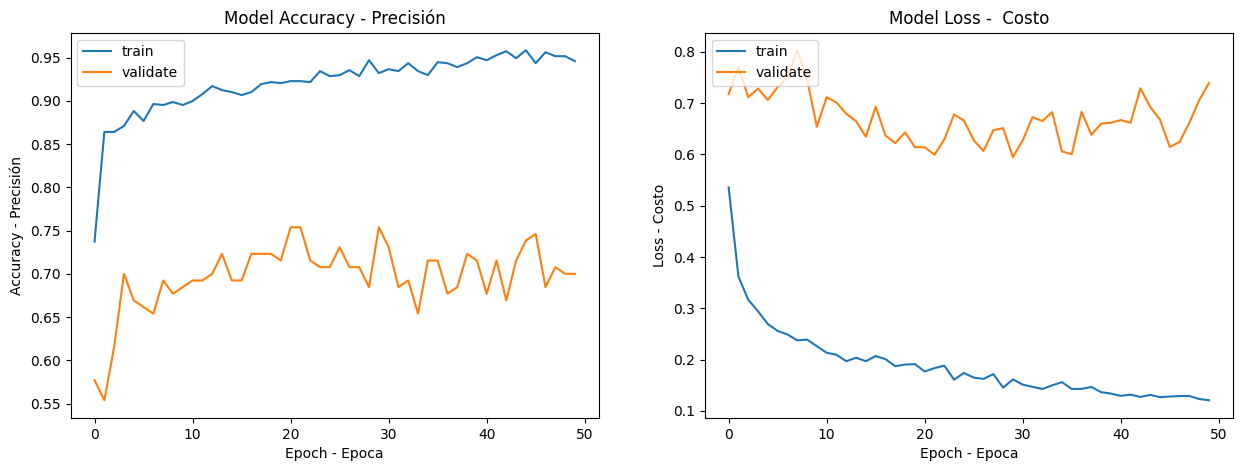

In [ ]:
plot_history(hist_mobile)

In [ ]:
# Evaluar el modelo
lossMobileNet, accuracyMobileNet = MobileNet_model.evaluate(validation_generator, steps=len(validation_generator))
print('Loss mobilenet:', lossMobileNet)
print('Accuracy mobilenet:', accuracyMobileNet)

5/5 [==============================] - 3s 517ms/step - loss: 0.7301 - accuracy: 0.6923
Loss mobilenet: 0.7300564050674438
Accuracy mobilenet: 0.692307710647583


In [ ]:
model_base.save('/content/drive/MyDrive/modelos/isic/aclarado_Clahe__224x224_mobilenet.keras')

# Xception

In [ ]:
Xception_base = Xception(weights='imagenet', include_top=False)

x = Xception_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
predictions = layers.Dense(int(len(train_generator.class_indices.keys())), activation='softmax')(x)
Xception_transfer = models.Model(inputs=Xception_base.input, outputs=predictions)

83683744/83683744 [==============================] - 4s 0us/step


In [ ]:
Xception_transfer.compile(loss='categorical_crossentropy',
                          optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9),
                          metrics=['accuracy'])

In [ ]:
historyXception = Xception_transfer.fit(train_generator,
                                                  epochs=num_epochs,
                                                  shuffle = True,
                                                  verbose = 1,
                                                  validation_data = validation_generator)

Epoch 1/50
28/28 [==============================] - 32s 622ms/step - loss: 0.5683 - accuracy: 0.8226 - val_loss: 0.5992 - val_accuracy: 0.6923
Epoch 2/50
28/28 [==============================] - 16s 579ms/step - loss: 0.5001 - accuracy: 0.8537 - val_loss: 0.5653 - val_accuracy: 0.6923
Epoch 3/50
28/28 [==============================] - 17s 591ms/step - loss: 0.4464 - accuracy: 0.8629 - val_loss: 0.5569 - val_accuracy: 0.6923
Epoch 4/50
28/28 [==============================] - 16s 585ms/step - loss: 0.4182 - accuracy: 0.8629 - val_loss: 0.5926 - val_accuracy: 0.6923
Epoch 5/50
28/28 [==============================] - 16s 580ms/step - loss: 0.3992 - accuracy: 0.8629 - val_loss: 0.6151 - val_accuracy: 0.6923
Epoch 6/50
28/28 [==============================] - 16s 584ms/step - loss: 0.3787 - accuracy: 0.8629 - val_loss: 0.6377 - val_accuracy: 0.6923
Epoch 7/50
28/28 [==============================] - 16s 584ms/step - loss: 0.3694 - accuracy: 0.8629 - val_loss: 0.6467 - val_accuracy: 0.6923

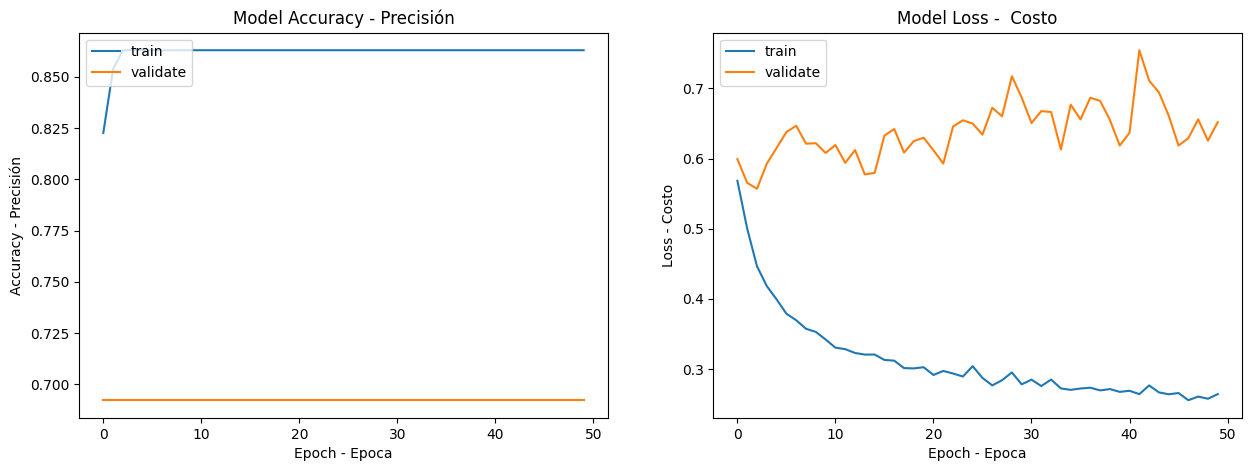

In [ ]:
plot_history(historyXception)

In [ ]:
# Evaluar el modelo
lossXception, accuracyXception = Xception_transfer.evaluate(validation_generator, steps=len(validation_generator))
print('Loss Xception:', lossXception)
print('Accuracy Xception:', accuracyXception)

5/5 [==============================] - 3s 522ms/step - loss: 0.6455 - accuracy: 0.6923
Loss Xception: 0.6455068588256836
Accuracy Xception: 0.692307710647583


In [ ]:
Xception_base.save('/content/drive/MyDrive/modelos/isic/aclarado_Clahe_224x224_Xception.keras')

# InceptionV3

In [ ]:
model_base = InceptionV3(weights='imagenet',include_top=False)

x = model_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512,activation='relu')(x)
predictions = layers.Dense(int(len(train_generator.class_indices.keys())) ,activation='softmax')(x)
InceptionV3_model = models.Model(inputs= model_base.input, outputs=predictions)

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
InceptionV3_model.compile(loss='categorical_crossentropy',
                          optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9) ,
                          metrics=['accuracy'])

In [ ]:
historyInceptionV3 = InceptionV3_model.fit(train_generator,
                                                     epochs=num_epochs,
                                                     shuffle=True,
                                                     verbose=1,
                                                     validation_data=validation_generator)

Epoch 1/50
28/28 [==============================] - 40s 702ms/step - loss: 0.6156 - accuracy: 0.6221 - val_loss: 0.6274 - val_accuracy: 0.7000
Epoch 2/50
28/28 [==============================] - 16s 589ms/step - loss: 0.3893 - accuracy: 0.8629 - val_loss: 0.6399 - val_accuracy: 0.6923
Epoch 3/50
28/28 [==============================] - 16s 584ms/step - loss: 0.3499 - accuracy: 0.8618 - val_loss: 0.6535 - val_accuracy: 0.6923
Epoch 4/50
28/28 [==============================] - 16s 584ms/step - loss: 0.3322 - accuracy: 0.8629 - val_loss: 0.6315 - val_accuracy: 0.6846
Epoch 5/50
28/28 [==============================] - 16s 585ms/step - loss: 0.3241 - accuracy: 0.8675 - val_loss: 0.5961 - val_accuracy: 0.7000
Epoch 6/50
28/28 [==============================] - 16s 604ms/step - loss: 0.3201 - accuracy: 0.8675 - val_loss: 0.5796 - val_accuracy: 0.6769
Epoch 7/50
28/28 [==============================] - 16s 581ms/step - loss: 0.2941 - accuracy: 0.8675 - val_loss: 0.6107 - val_accuracy: 0.7154

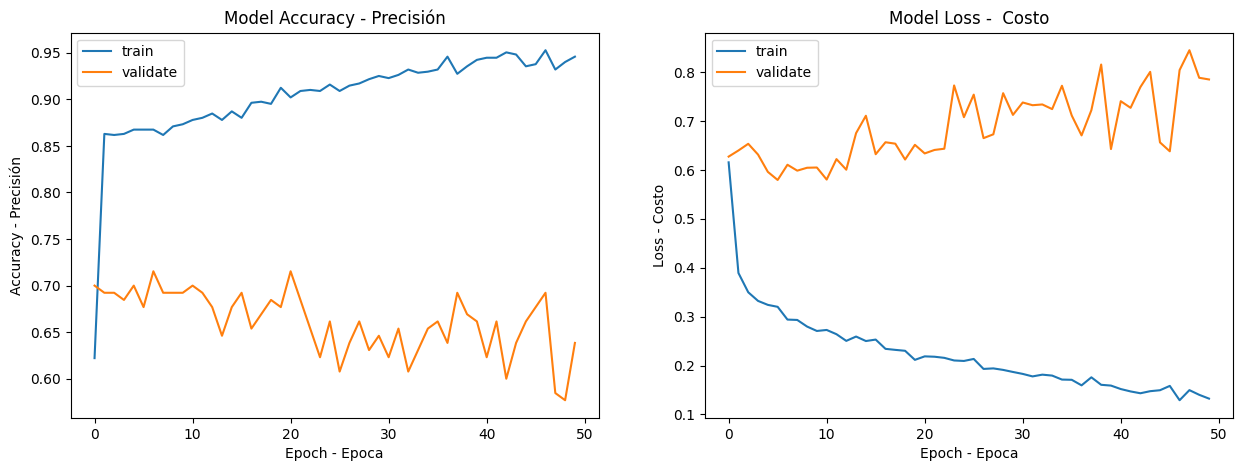

In [ ]:
plot_history(historyInceptionV3)

In [ ]:
# Evaluar el modelo
lossInceptionV3, accuracyInceptionV3 = InceptionV3_model.evaluate(validation_generator, steps=len(validation_generator))
print('Loss InceptionV3:', lossInceptionV3)
print('Accuracy InceptionV3:', accuracyInceptionV3)

5/5 [==============================] - 3s 534ms/step - loss: 0.8972 - accuracy: 0.5846
Loss InceptionV3: 0.8972174525260925
Accuracy InceptionV3: 0.5846154093742371


In [ ]:
InceptionV3_model.save('/content/drive/MyDrive/modelos/isic/aclarado_Clahe_224x224_InceptionV3.keras')

# VGG-16

In [ ]:
model_base = VGG16(weights='imagenet',include_top=False)

x = model_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512,activation='relu')(x)
predictions = layers.Dense(int(len(train_generator.class_indices.keys())) ,activation='softmax')(x)
Vgg16_model = models.Model(inputs= model_base.input, outputs=predictions)

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
Vgg16_model.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9) ,
                    metrics=['accuracy'])

In [ ]:
historyVgg16 = Vgg16_model.fit(train_generator,
                                         epochs=num_epochs,
                                         shuffle=True,
                                         verbose=1,
                                         validation_data=validation_generator)

Epoch 1/50
28/28 [==============================] - 22s 584ms/step - loss: 0.4164 - accuracy: 0.8629 - val_loss: 0.7047 - val_accuracy: 0.6923
Epoch 2/50
28/28 [==============================] - 16s 583ms/step - loss: 0.3699 - accuracy: 0.8629 - val_loss: 0.6797 - val_accuracy: 0.6923
Epoch 3/50
28/28 [==============================] - 16s 579ms/step - loss: 0.3413 - accuracy: 0.8629 - val_loss: 0.6742 - val_accuracy: 0.6923
Epoch 4/50
28/28 [==============================] - 16s 577ms/step - loss: 0.3177 - accuracy: 0.8629 - val_loss: 0.6355 - val_accuracy: 0.6923
Epoch 5/50
28/28 [==============================] - 16s 586ms/step - loss: 0.2943 - accuracy: 0.8606 - val_loss: 0.6478 - val_accuracy: 0.7000
Epoch 6/50
28/28 [==============================] - 16s 577ms/step - loss: 0.2803 - accuracy: 0.8687 - val_loss: 0.7321 - val_accuracy: 0.7000
Epoch 7/50
28/28 [==============================] - 17s 597ms/step - loss: 0.2696 - accuracy: 0.8779 - val_loss: 0.6253 - val_accuracy: 0.7308

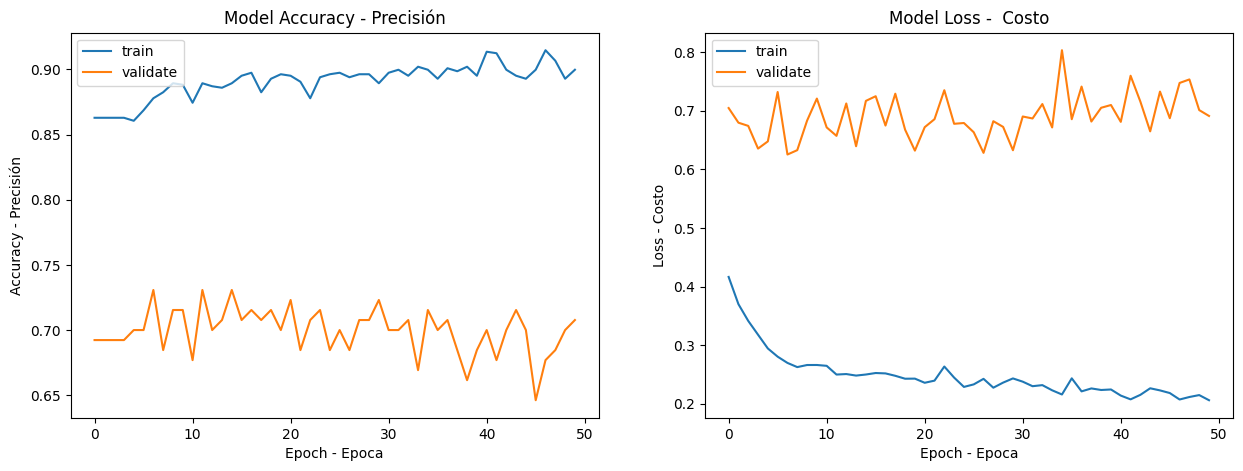

In [ ]:
plot_history(historyVgg16)

In [ ]:
# Evaluar el modelo
lossVgg16, accuracyVgg16 = Vgg16_model.evaluate(validation_generator, steps=len(validation_generator))
print('Loss Vgg16:', lossVgg16)
print('Accuracy Vgg16:', accuracyVgg16)

5/5 [==============================] - 3s 504ms/step - loss: 0.6954 - accuracy: 0.6769
Loss Vgg16: 0.6953675746917725
Accuracy Vgg16: 0.6769230961799622


In [ ]:
Vgg16_model.save('/content/drive/MyDrive/modelos/isic/aclarado_Clahe_224x224_Vgg16.keras')

# VGG-19

In [ ]:
model_base = VGG19(weights='imagenet',include_top=False)

x = model_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512,activation='relu')(x)
predictions = layers.Dense(int(len(train_generator.class_indices.keys())) ,activation='softmax')(x)
Vgg19_model = models.Model(inputs= model_base.input, outputs=predictions)

80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
Vgg19_model.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9) ,
                    metrics=['accuracy'])

In [ ]:
historyVgg19 = Vgg19_model.fit(train_generator,
                                         epochs=num_epochs,
                                         shuffle=True,
                                         verbose=1,
                                         validation_data=validation_generator)

Epoch 1/50
28/28 [==============================] - 19s 592ms/step - loss: 0.5056 - accuracy: 0.7143 - val_loss: 0.7749 - val_accuracy: 0.6923
Epoch 2/50
28/28 [==============================] - 16s 575ms/step - loss: 0.3794 - accuracy: 0.8629 - val_loss: 0.6796 - val_accuracy: 0.6923
Epoch 3/50
28/28 [==============================] - 16s 570ms/step - loss: 0.3496 - accuracy: 0.8629 - val_loss: 0.6496 - val_accuracy: 0.6923
Epoch 4/50
28/28 [==============================] - 16s 588ms/step - loss: 0.3250 - accuracy: 0.8629 - val_loss: 0.6781 - val_accuracy: 0.6923
Epoch 5/50
28/28 [==============================] - 16s 577ms/step - loss: 0.3011 - accuracy: 0.8629 - val_loss: 0.6563 - val_accuracy: 0.6923
Epoch 6/50
28/28 [==============================] - 16s 591ms/step - loss: 0.2908 - accuracy: 0.8675 - val_loss: 0.5923 - val_accuracy: 0.7154
Epoch 7/50
28/28 [==============================] - 16s 600ms/step - loss: 0.2731 - accuracy: 0.8733 - val_loss: 0.5949 - val_accuracy: 0.7385

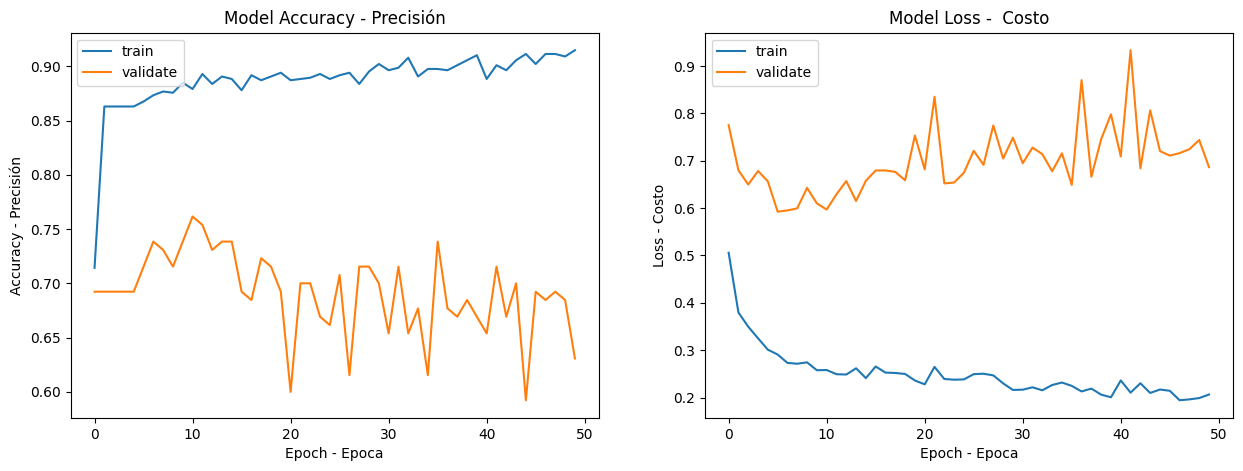

In [ ]:
plot_history(historyVgg19)

In [ ]:
# Evaluar el modelo
lossVgg19, accuracyVgg19 = Vgg19_model.evaluate(validation_generator, steps=len(validation_generator))
print('Loss Vgg19:', lossVgg19)
print('Accuracy Vgg19:', accuracyVgg19)

5/5 [==============================] - 3s 502ms/step - loss: 0.7097 - accuracy: 0.6385
Loss Vgg19: 0.7096660137176514
Accuracy Vgg19: 0.6384615302085876


In [ ]:
Vgg19_model.save('/content/drive/MyDrive/modelos/isic/aclarado_Clahe_224x224_Vgg19.keras')

# EfficientNet

In [ ]:
model_base = EfficientNetB7(weights='imagenet',include_top=False)
x = model_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512,activation='relu')(x)
predictions = layers.Dense(int(len(train_generator.class_indices.keys())) ,activation='softmax')(x)
EfficientNetB7_model = models.Model(inputs= model_base.input, outputs=predictions)

258076736/258076736 [==============================] - 12s 0us/step


In [ ]:
EfficientNetB7_model.compile(loss='categorical_crossentropy',
                             optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9) ,
                             metrics=['accuracy'])

In [ ]:
historyEfficientNet = EfficientNetB7_model.fit(train_generator,
                                                         epochs=num_epochs,
                                                         shuffle=True,
                                                         verbose=1,
                                                         validation_data=validation_generator)

Epoch 1/50
28/28 [==============================] - 100s 815ms/step - loss: 0.6577 - accuracy: 0.6394 - val_loss: 0.7074 - val_accuracy: 0.3077
Epoch 2/50
28/28 [==============================] - 17s 599ms/step - loss: 0.6037 - accuracy: 0.7523 - val_loss: 0.6303 - val_accuracy: 0.6923
Epoch 3/50
28/28 [==============================] - 17s 605ms/step - loss: 0.5734 - accuracy: 0.8076 - val_loss: 0.6190 - val_accuracy: 0.6923
Epoch 4/50
28/28 [==============================] - 17s 615ms/step - loss: 0.5320 - accuracy: 0.8318 - val_loss: 0.6333 - val_accuracy: 0.6923
Epoch 5/50
28/28 [==============================] - 17s 607ms/step - loss: 0.5036 - accuracy: 0.8537 - val_loss: 0.6911 - val_accuracy: 0.6923
Epoch 6/50
28/28 [==============================] - 17s 599ms/step - loss: 0.4885 - accuracy: 0.8537 - val_loss: 0.7655 - val_accuracy: 0.6923
Epoch 7/50
28/28 [==============================] - 17s 594ms/step - loss: 0.4623 - accuracy: 0.8652 - val_loss: 0.8314 - val_accuracy: 0.692

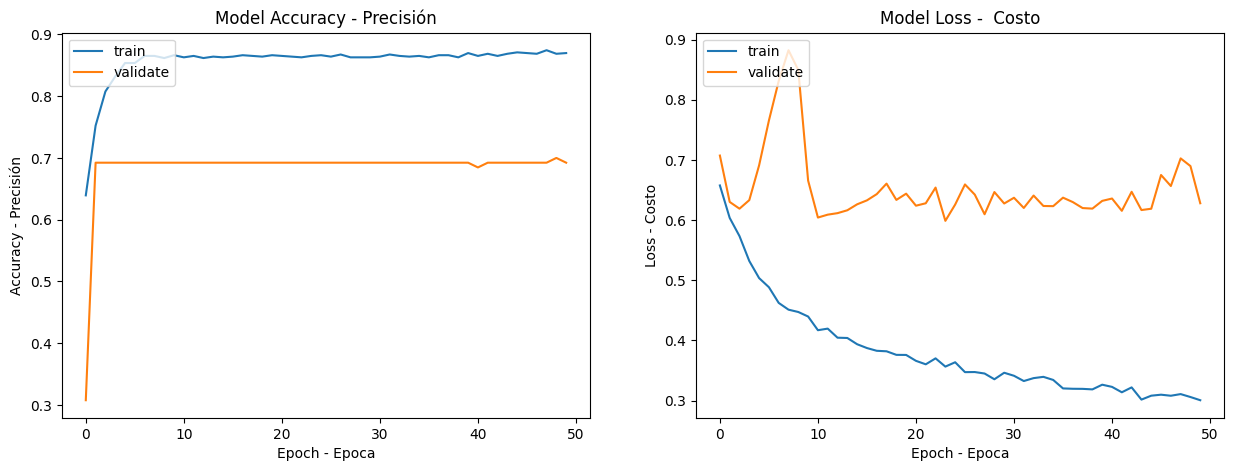

In [ ]:
plot_history(historyEfficientNet)

In [ ]:
# Evaluar el modelo
lossEfficientNetB7, accuracyEfficientNetB7 = EfficientNetB7_model.evaluate(validation_generator, steps=len(validation_generator))
print('Loss EfficientNetB7:', lossEfficientNetB7)
print('Accuracy EfficientNetB7:', accuracyEfficientNetB7)

5/5 [==============================] - 3s 516ms/step - loss: 0.6446 - accuracy: 0.6923
Loss EfficientNetB7: 0.6445862650871277
Accuracy EfficientNetB7: 0.692307710647583


In [ ]:
EfficientNetB7_model.save('/content/drive/MyDrive/modelos/isic/aclarado_Clahe_224x224_EfficientNet.keras')

In [ ]:
# Cargar la imagen que deseas predecir
image_path = '/content/drive/MyDrive/imagen_paula2.jpg'
image_path = '/content/drive/MyDrive/ISIC_9967383.jpg'

img = tf.keras.preprocessing.image.load_img(image_path, target_size=(tamano_imagen, tamano_imagen))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0
predictions = EfficientNetB7_model.predict(x)
predicted_class = np.argmax(predictions[0])
class_labels = train_generator.class_indices
for class_label, class_index in class_labels.items():
    if class_index == predicted_class:
        print('PREDICCION DEL MODELO:', class_label)
    class_label
#imshow(img)

# Imprimir las predicciones
for pred in predictions:
    print(f'{pred[0]}: {pred[1]*100}%')
    print(f'{pred[0]}')
    print(f'{pred[1]}')
    print(f'{pred[1]*100}%')
#preprocessed_image = preprocess_image('input.jpg')
#predicted_output = mobile.predict(preprocessed_image)
#results_decoded = decode_predictions(predictions, top=3)[0]
#print("The predicted labels along with their respective probabilities are as follows:")
#display_results(results_decoded)

1/1 [==============================] - 5s 5s/step
PREDICCION DEL MODELO: benign
0.7796492576599121: 22.03507572412491%
0.7796492576599121
0.22035075724124908
22.03507572412491%


In [ ]:
def decode_predictions(preds, top=5):
    """Decodes the prediction of an ImageNet model.

    Args:
      preds: Numpy array encoding a batch of predictions.
      top: Integer, how many top-guesses to return. Defaults to 5.

    Returns:
      A list of lists of top class prediction tuples
      `(class_name, class_description, score)`.
      One list of tuples per sample in batch input.

    Raises:
      ValueError: In case of invalid shape of the `pred` array
        (must be 2D).
    """
    global CLASS_INDEX

    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError(
            "`decode_predictions` expects "
            "a batch of predictions "
            "(i.e. a 2D array of shape (samples, 1000)). "
            "Found array with shape: " + str(preds.shape)
        )
    if CLASS_INDEX is None:
        fpath = data_utils.get_file(
            "imagenet_class_index.json",
            CLASS_INDEX_PATH,
            cache_subdir="models",
            file_hash="c2c37ea517e94d9795004a39431a14cb",
        )
        with open(fpath) as f:
            CLASS_INDEX = json.load(f)
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

In [ ]:
# Cargar la imagen que deseas predecir
image_path = '/content/drive/MyDrive/ISIC_9963177.jpg'
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(tamano_imagen, tamano_imagen))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0
# Realizar la predicción
predictions = EfficientNetB7_model.predict(x)

predictions

1/1 [==============================] - 0s 48ms/step


array([[0.8068752 , 0.19312479]], dtype=float32)

In [ ]:
# Imprimir las predicciones
for pred in predictions:
    print(f'{pred[0]*100}%')

In [ ]:


test_images = [
    "/content/drive/MyDrive/BENISIC_9997614.jpg",
    "/content/drive/MyDrive/BENISIC_9998937.jpg",
    "/content/drive/MyDrive/BENISIC_9999251.jpg",
    "/content/drive/MyDrive/ISIC_9963177.jpg",
    "/content/drive/MyDrive/ISIC_9967383.jpg",
    "/content/drive/MyDrive/ISIC_9978107.jpg",
    "/content/drive/MyDrive/ISIC_9998679.jpg",
    "/content/drive/MyDrive/ISIC_9900191.jpg",
    "/content/drive/MyDrive/ISIC_9907020.jpg"
]

test_labels = ["benign", "malignant"]

1/1 [==============================] - 0s 45ms/step


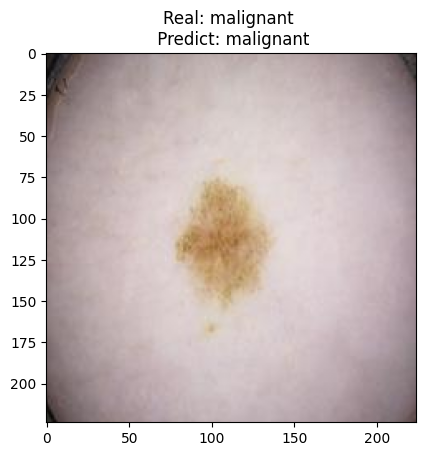

1/1 [==============================] - 0s 42ms/step


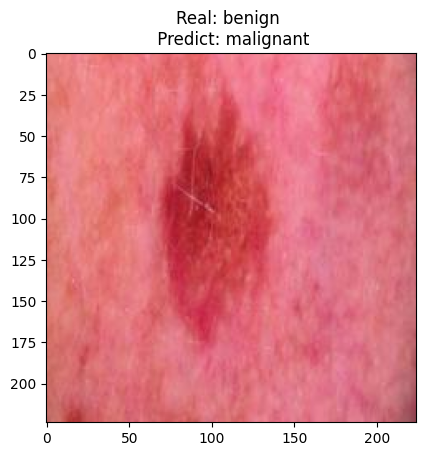

In [ ]:

for (i,label) in enumerate(test_labels):
    img = load_img(test_images[i],target_size=(224,224))
    #response = requests.get(test_images[i])
    #img = Image.open(BytesIO(response.content))
    img = np.asarray(img)/255.
    img = cv2.resize(img, (224,224))
    prediction=EfficientNetB7_model.predict(img.reshape(1, 224,224,3))
    output = np.argmax(prediction)

    plt.title("Real: {} \n Predict: {}".format(imagen_dematologica[i], imagen_dematologica[output]))
    plt.imshow(img)
    plt.show()

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
# Cargar la imagen y la característica a comparar
img = cv2.imread('/content/real/train/malignant/ISIC_0000004.jpg')
feature = cv2.imread('ISIC_0000004.jpg', 0)
# Extraer características de la imagen con ORB
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img, None)
kp2, des2 = orb.detectAndCompute(feature, None)
# Configurar el algoritmo de comparación de características
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Realizar la comparación de características
matches = bf.match(des1, des2)
# Ordenar las coincidencias y seleccionar las mejores
matches = sorted(matches, key = lambda x: x.distance)
best_matches = matches[:10]
# Dibujar las mejores coincidencias en la imagen
img3 = cv2.drawMatches(img, kp1, feature, kp2, best_matches, None, flags=2)
# Mostrar la imagen con las mejores coincidencias
cv2_imshow(img3)
#cv2.waitKey()
#cv2.destroyAllWindows()

error: ignored

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
# Cargar la imagen y la característica a comparar
img = cv2.imread('/content/drive/MyDrive/Oscurecer-Aclarar/real/train/malignant/ISIC_0000002.jpg')
feature = cv2.imread('ISIC_0000002.jpg', 0)
# Extraer características de la imagen con ORB
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img, None)
kp2, des2 = orb.detectAndCompute(feature, None)
# Configurar el algoritmo de comparación de características
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Realizar la comparación de características
matches = bf.match(des1, des2)
# Ordenar las coincidencias y seleccionar las mejores
matches = sorted(matches, key = lambda x: x.distance)
best_matches = matches[:10]
# Dibujar las mejores coincidencias en la imagen
img3 = cv2.drawMatches(img, kp1, feature, kp2, best_matches, None, flags=2)
# Mostrar la imagen con las mejores coincidencias
cv2_imshow(img3)
#cv2.waitKey()
#cv2.destroyAllWindows()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#CARGAMOS IMAGEN ORIGINAL EN MODO "RGB"
ruta_imagen='/content/ISIC_0000026.jpg'
ruta_imagen_mod='/content/ISIC_0000022_mod.jpg'
img = cv2.cvtColor(cv2.imread(ruta_imagen),cv2.COLOR_BGR2RGB)

Mblur = cv2.medianBlur(img,9)

blur=cv2.blur(img, (5, 5))

cv2.imwrite(ruta_imagen_mod, blur)

imshow(img)
imshow(blur)
imshow(Mblur)
